In [15]:

%pip install imbalanced-learn

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Instantiate RandomForestClassifier to avoid "not accessed" warning
_ = RandomForestClassifier()

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

from imblearn.over_sampling import SMOTE

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Load dataset

In [16]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Initial data inspection


In [17]:
print("Dataset shape (rows, columns):", df.shape)
print("\nSample data:")
print(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape (rows, columns): (7043, 21)

Sample data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  Tech

Convert 'TotalCharges' to numeric, coercing errors to NaN

In [18]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

print("\nNumerical columns description:")
print(df.describe())

print("\nCategorical columns description:")
print(df.describe(include='object'))

# Show first 5 unique values of each column for quick overview
for col in df.columns:
    print(f"{col}: {df[col].unique()[:5]}")



Numerical columns description:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

Categorical columns description:
        customerID gender Partner Dependents PhoneService MultipleLines  \
count         7043   7043    7043       7043         7043          7043   
unique        7043      2       2          2            2             3   
top     7590-VHVEG   Male      No         No          Yes            No   
freq             1   3555    3641       4933         6361 

In [19]:
replace_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

binary_cols = replace_cols + ['Churn']
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

df.drop('customerID', axis=1, inplace=True)

df = pd.get_dummies(df, drop_first=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12572\953530679.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})


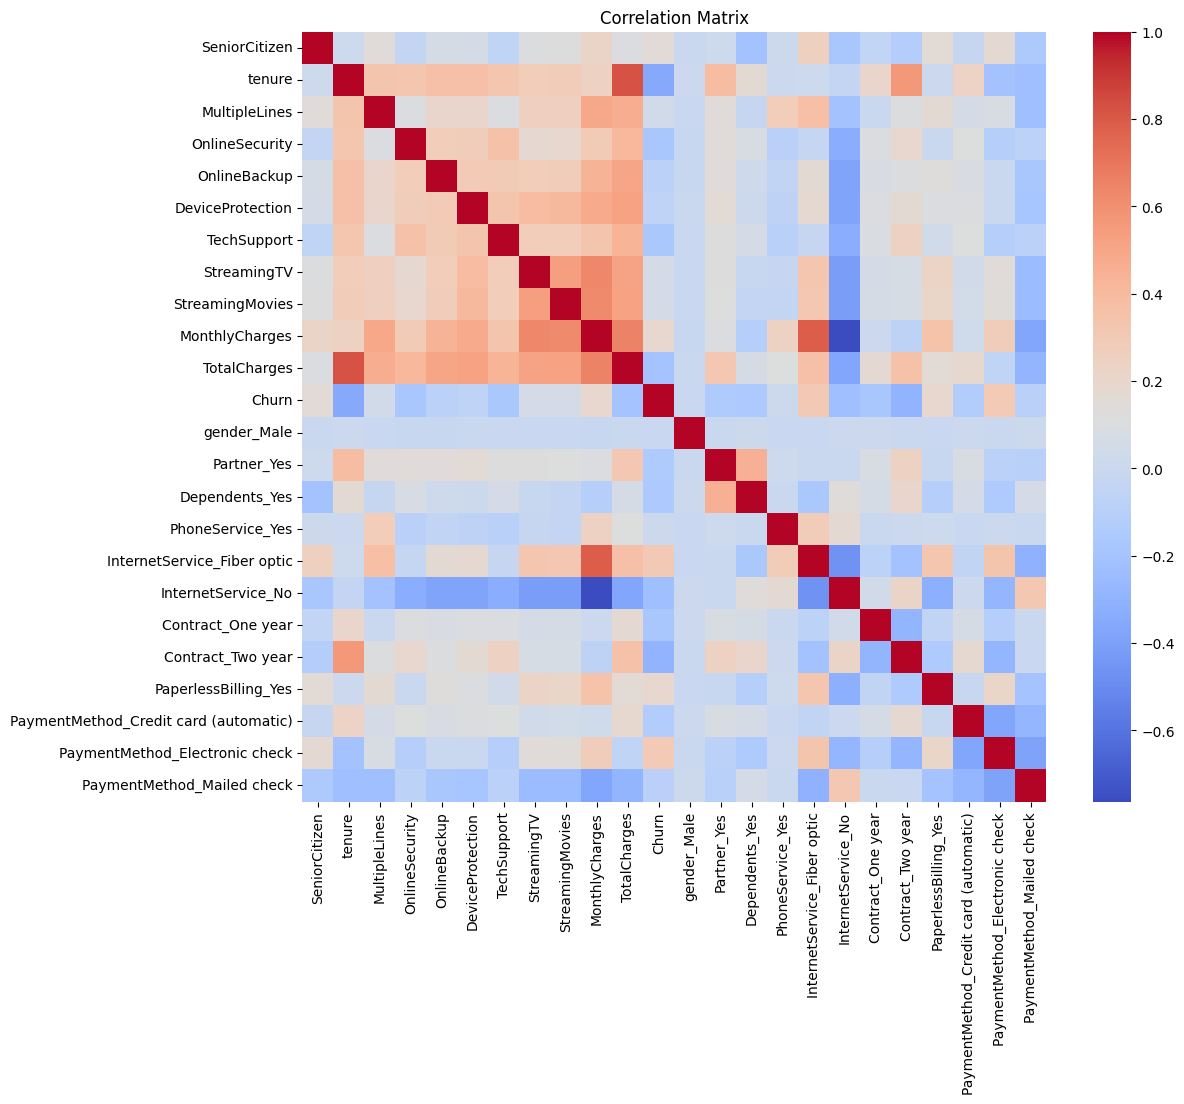


Correlation with Churn:
Churn                                    1.000000
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
MonthlyCharges                           0.192858
PaperlessBilling_Yes                     0.191454
SeniorCitizen                            0.150541
StreamingTV                              0.063254
StreamingMovies                          0.060860
MultipleLines                            0.040033
PhoneService_Yes                         0.011691
gender_Male                             -0.008545
DeviceProtection                        -0.066193
OnlineBackup                            -0.082307
PaymentMethod_Mailed check              -0.090773
PaymentMethod_Credit card (automatic)   -0.134687
Partner_Yes                             -0.149982
Dependents_Yes                          -0.163128
TechSupport                             -0.164716
OnlineSecurity                          -0.171270
Contract_One year        

In [23]:
pd.set_option('display.max_columns', None)

corr_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

churn_corr = df.corr()['Churn'].sort_values(ascending=False)
print("\nCorrelation with Churn:")
print(churn_corr)

selected_features = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'InternetService_Fiber optic',
    'InternetService_No',
    'PaymentMethod_Electronic check',
    'Contract_One year',
    'Contract_Two year',
    'PaperlessBilling_Yes',
    'OnlineSecurity',
    'TechSupport',
    'SeniorCitizen',
    'Partner_Yes',
    'Dependents_Yes',
    'StreamingTV',
    'StreamingMovies'
]

df.dropna(subset=['TotalCharges'], inplace=True)

X = df[selected_features]
y = df['Churn']

 Split dataset

In [24]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Models


Logistic Regression Performance:
Accuracy : 0.7882
Precision: 0.6188
Recall   : 0.5294
F1 Score : 0.5706


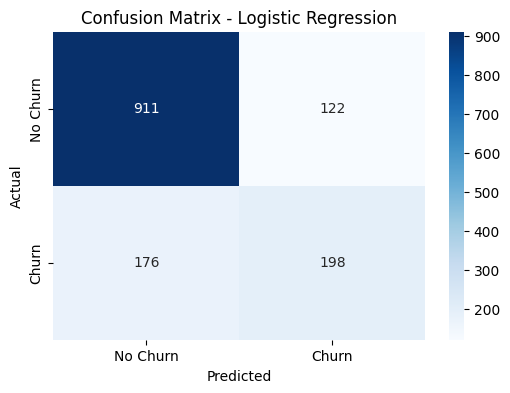


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    No Churn       0.84      0.88      0.86      1033
       Churn       0.62      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407


Random Forest Performance:
Accuracy : 0.7832
Precision: 0.6228
Recall   : 0.4679
F1 Score : 0.5344


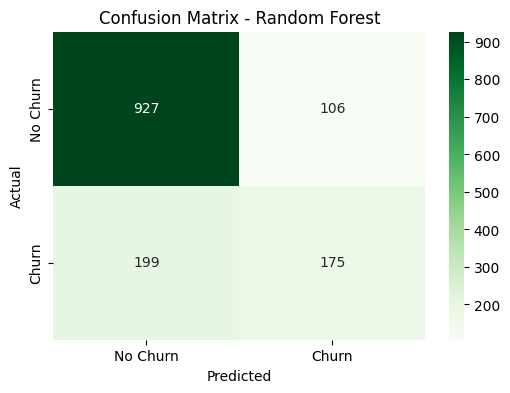


Classification Report (Random Forest):
              precision    recall  f1-score   support

    No Churn       0.82      0.90      0.86      1033
       Churn       0.62      0.47      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [16:04:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Performance:
Accuracy : 0.7740
Precision: 0.5915
Recall   : 0.4840
F1 Score : 0.5324


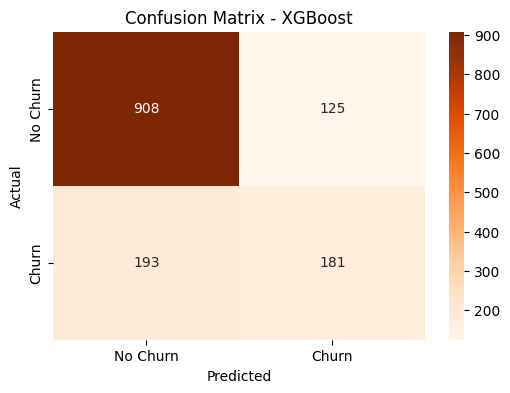


Classification Report (XGBoost):
              precision    recall  f1-score   support

    No Churn       0.82      0.88      0.85      1033
       Churn       0.59      0.48      0.53       374

    accuracy                           0.77      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.77      0.77      1407

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters (GridSearch):
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best Random Forest Performance (GridSearch):
Accuracy : 0.7605
Precision: 0.5389
Recall   : 0.6845
F1 Score : 0.6031


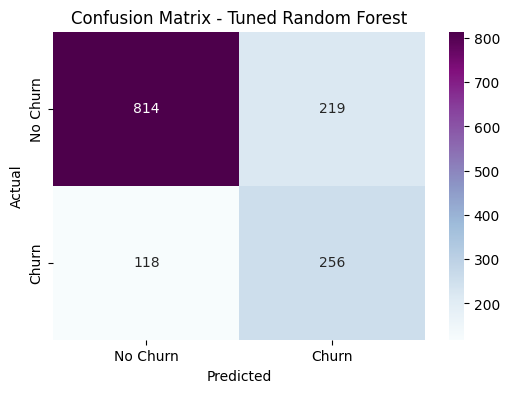


Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

    No Churn       0.87      0.79      0.83      1033
       Churn       0.54      0.68      0.60       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.78      0.76      0.77      1407


Shape before SMOTE: (5625, 16)
Shape after SMOTE : (8260, 16)

Random Forest Performance with SMOTE Balanced Data:
Accuracy : 0.7562
Precision: 0.5333
Recall   : 0.6631
F1 Score : 0.5912

Classification Report (Random Forest + SMOTE):
              precision    recall  f1-score   support

    No Churn       0.87      0.79      0.83      1033
       Churn       0.53      0.66      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.76      1407


Top 10 Important Features:
                           Feature  

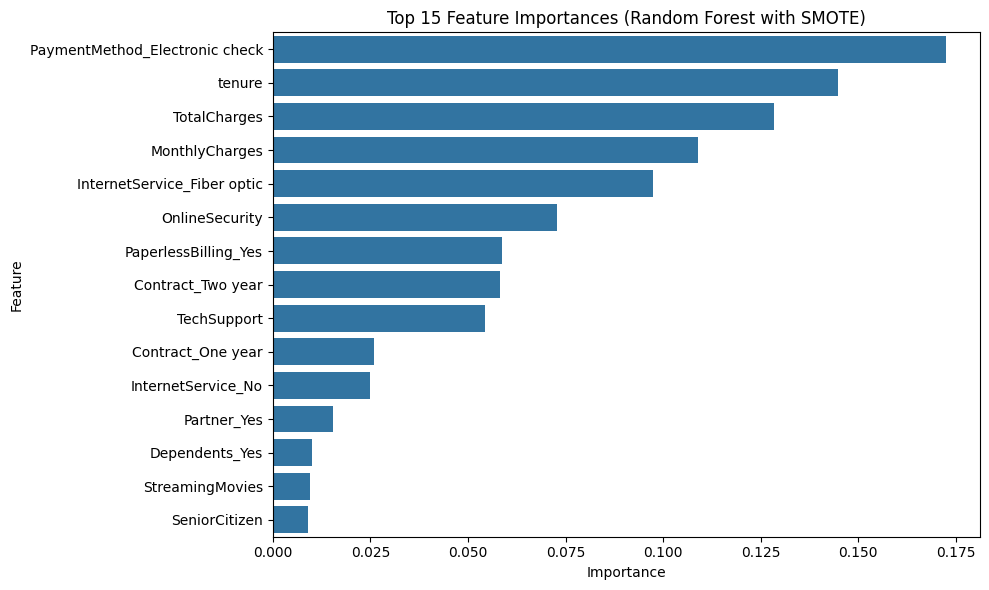

In [25]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("\nLogistic Regression Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_lr):.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))


rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_rf):.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_xgb):.4f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))


# GridSearch for Random Forest
rf_base = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(rf_base, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("\nBest Parameters (GridSearch):")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

print("\nBest Random Forest Performance (GridSearch):")
print(f"Accuracy : {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best_rf):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_best_rf):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_best_rf):.4f}")

cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='BuPu', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.show()

print("\nClassification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_best_rf, target_names=['No Churn', 'Churn']))


# SMOTE for balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

print("\nShape before SMOTE:", X_train.shape)
print("Shape after SMOTE :", X_balanced.shape)

rf_smote = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1,
                                  min_samples_split=2, class_weight=None, random_state=42)
rf_smote.fit(X_balanced, y_balanced)
y_pred_smote = rf_smote.predict(X_test)

print("\nRandom Forest Performance with SMOTE Balanced Data:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_smote):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_smote):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_smote):.4f}")

print("\nClassification Report (Random Forest + SMOTE):")
print(classification_report(y_test, y_pred_smote, target_names=['No Churn', 'Churn']))


# Feature importance plot
importances = rf_smote.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title("Top 15 Feature Importances (Random Forest with SMOTE)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
